In [26]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import torch

import numpy as np
import matplotlib.pyplot as plt

plt.ion()
from IPython.display import clear_output

from utils import *
from wgan import *


cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

""" So generally both torch.Tensor and torch.cuda.Tensor are equivalent. You can do everything you like with them both.
The key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory.
Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU."""

##############################################
# Defining all hyperparameters
##############################################


class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


hp = Hyperparameters(
    n_epochs=200,
    batch_size=64,
    lr=0.00005,
    n_cpu=8,
    latent_dim=100,
    img_size=32,
    channels=1,
    n_critic=25,
    clip_value=0.005,
    sample_interval=400,
)

In [27]:
import torch.utils

root_path = '/Users/abhinaybelde/Desktop/Learning/All-About-GANs/WGAN/Basic_WGAN/datasets'

train_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        root_path,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(hp.img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        ),
    ),
    batch_size = hp.batch_size,
    shuffle=True,
)

In [31]:
from utils import *
from wgan import *

img_shape = (hp.channels, hp.img_size, hp.img_size)

generator = Generator(img_shape, hp.latent_dim)
critic = Critic(img_shape)


In [32]:
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr= hp.lr)
optimizer_D = torch.optim.RMSprop(critic.parameters(), lr=hp.lr)

In [33]:
generator.apply(weights_init_normal)
critic.apply(weights_init_normal)

Critic(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Epoch:199:It538:DLoss-0.015063151717185974:GLoss-0.07506991177797318


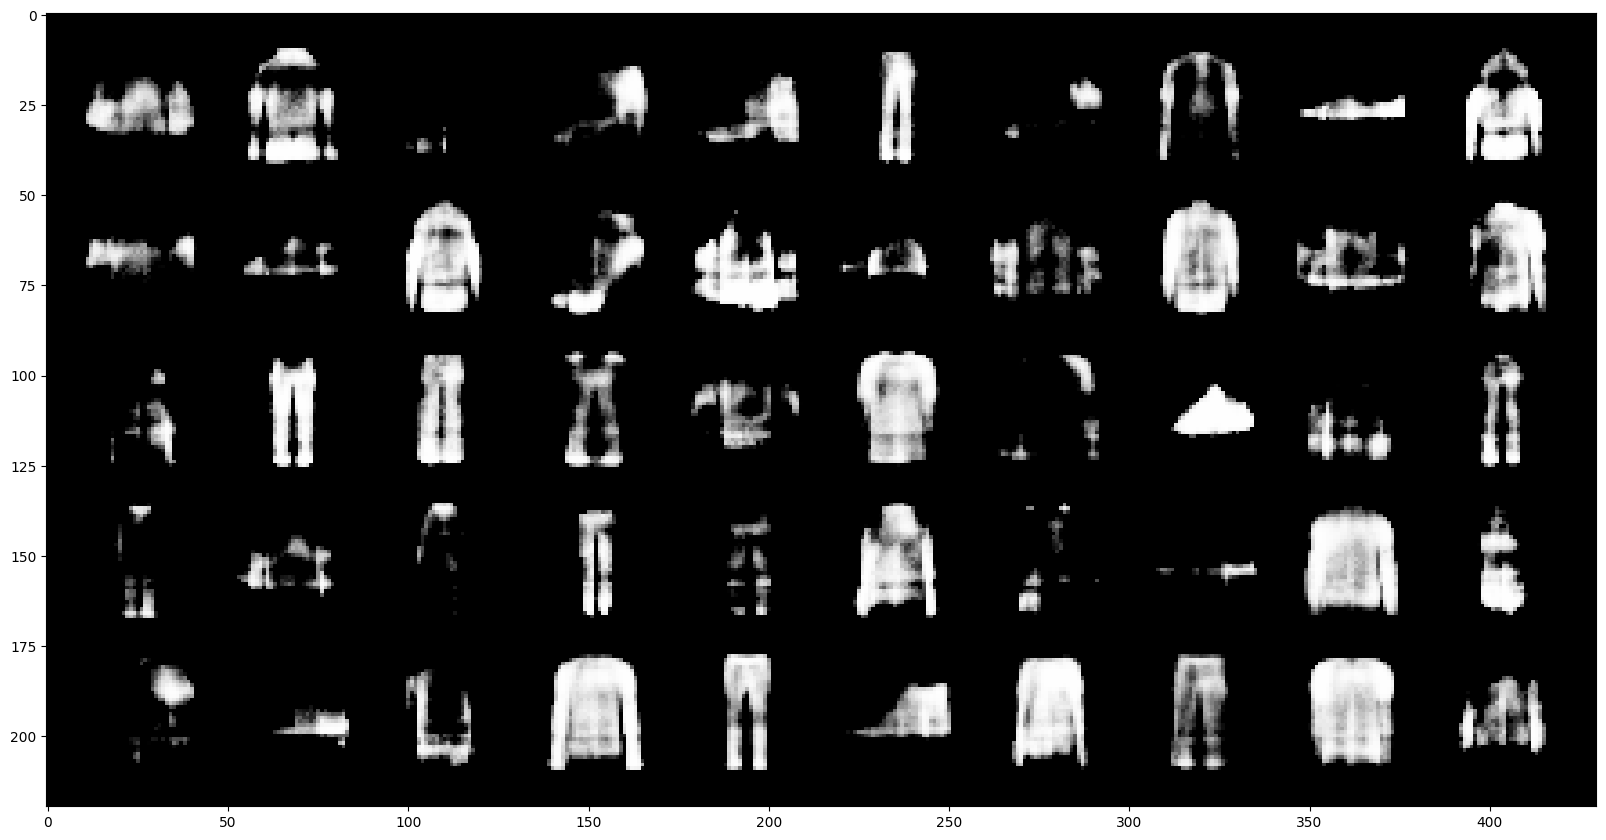

In [34]:
import torch
import numpy as np
from IPython.display import clear_output

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train():
    for epoch in range(hp.n_epochs):
        for i, (imgs, _) in enumerate(train_dataloader):

            # Adversarial ground truths
            valid = torch.ones((imgs.shape[0], 1), requires_grad=False).to(device)
            fake = torch.zeros((imgs.shape[0], 1), requires_grad=False).to(device)

            # Configure input
            real_imgs = imgs.to(device)

            #########################
            #  Train Critic
            #########################

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = torch.tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim)), dtype=torch.float32).to(device)

            # Generate a batch of images
            fake_imgs = generator(img_shape, z).detach()

            """ The math for the loss functions for the critic and generator is:
                Critic Loss: D(x) - D(G(z))
                -D(x) + D(G(z))
                Generator Loss: D(G(z))
                Now for the Critic Loss, as per the Paper, we have to maximize the expression.
                So, arithmetically, maximizing an expression, means minimizing the -ve of that expression
                i.e. -(D(x) - D(G(z))) which is -D(x) + D(G(z)) i.e. -D(real_imgs) + D(G(real_imgs))
            """
            d_loss = -torch.mean(critic(real_imgs)) + torch.mean(critic(fake_imgs))

            d_loss.backward()
            optimizer_D.step()

            """ Clip weights of critic to avoid vanishing/exploding gradients in the
            critic. """
            for p in critic.parameters():
                p.data.clamp_(-hp.clip_value, hp.clip_value)

            """ In WGAN, we update Critic more than Generator
            Train the generator every n_critic iterations
            we need to increase training iterations of the critic so that it works to
            approximate the real distribution sooner.
            """
            if i % hp.n_critic == 0:
                #########################
                #  Train Generator
                #########################
                optimizer_G.zero_grad()

                # Generate a batch of images
                fake_images_from_generator = generator(img_shape, z)
                # Adversarial loss
                g_loss = -torch.mean(critic(fake_images_from_generator))

                g_loss.backward()
                optimizer_G.step()

            ##################
            #  Log Progress
            ##################

            batches_done = epoch * len(train_dataloader) + i

            if batches_done % hp.sample_interval == 0:
                clear_output()
                print(f"Epoch:{epoch}:It{i}:DLoss{d_loss.item()}:GLoss{g_loss.item()}")
                visualise_output(fake_images_from_generator.data[:50], 10, 10)

train()
